In [1]:
%load_ext autoreload
%autoreload 2
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column

from mrf.celestial import Celestial, Star
from mrf.display import display_single, display_multiple

## Find stars (using gaia or something), select bright stars
`$ imcopy coadd_SloanR_NGC_5907.fits[900:1700,1900:2700] df_cutout.fits`

In [2]:
hdu = fits.open('df_cutout.fits')
img = hdu[0].data
header = hdu[0].header
w = wcs.WCS(header)
img -= float(header['BACKVAL'])
hdu.close()

In [8]:
## Query some bright stars from USNO
from mrf.utils import query_star
bright_star_cat = query_star(img, header, method='usno')
x, y = w.wcs_world2pix(bright_star_cat['ra'], bright_star_cat['dec'], 1)
bright_star_cat.add_columns([Column(data=x, name='x'), Column(data=y, name='y')])

### Online querying USNO data from VizieR. ###


In [9]:
# Only select bright stars, discard stars near the image boundaries
boundary = 50

flag = (bright_star_cat['x'] > boundary) & (bright_star_cat['x'] < img.shape[1] - boundary) & (
    bright_star_cat['y'] > boundary) & (bright_star_cat['y'] < img.shape[0] - boundary) & (
        bright_star_cat['Bmag'] < 15.5) & (bright_star_cat['Bmag'] > 10)
bright_star_cat = bright_star_cat[flag]

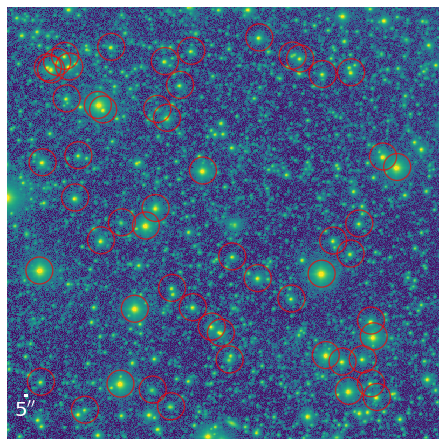

In [10]:
# Display their distribution
from mrf.display import draw_circles
draw_circles(img, bright_star_cat, pixel_scale=2.5, circle_size=50)

## Cutout stars, mask out contaminations, Stack them

In [11]:
from mrf.utils import extract_obj
# Detect all objects on the image
objects, segmap = extract_obj(img, b=64, f=3, sigma=5, minarea=5,
                              deblend_nthresh=32, deblend_cont=0.05, 
                              sky_subtract=False, show_fig=False, flux_aper=[3, 5])
ra, dec = w.wcs_pix2world(objects['x'], objects['y'], 1)
objects.add_columns([Column(data=ra, name='ra'), 
                     Column(data=dec, name='dec')])

# Detect 1244 objects


In [12]:
# Match detected objects with USNO stars
from astropy.coordinates import SkyCoord, match_coordinates_sky
temp = match_coordinates_sky(SkyCoord(ra=bright_star_cat['ra'], dec=bright_star_cat['dec'], unit='deg'),
                             SkyCoord(ra=objects['ra'], dec=objects['dec'], unit='deg'))[0]
bright_cat = objects[np.unique(temp)]

In [13]:
bright_cat.sort('flux')
bright_cat.reverse()

In [37]:
# Cutout stars, mask out contaminations and stack them.
# Only bright stars (top 30 for example)
star_set = []
for obj in bright_cat[:30]:
    star = Star(img, header, obj, colnames=['x', 'y'], halosize=50, padsize=50)
    star.mask_out_contam(cval=np.nan, show_fig=False, verbose=False)
    # Here could be problematic. When centralized a star in which contaminations has already been masked, 
    # the interpolation could make everything messy.
    # Interpolation cannot be done on `np.nan`, so the masked region is replaced by zeros. 
    # But, these zeros are no longer zeros after interpolation, but most of them still are. 
    # So I replace zeros with `np.nan` again.
    star.centralize(method='iraf')
    star.image[star.image == 0] = np.nan
    star_set.append(star.image / star.fluxann)
    # Here I normalize each cutout with flux_ann, which is the flux between 3 arcsec and 5 arcsec, 
    # to avoid possible issues with saturated centers.

In [38]:
star_set = np.asarray(star_set)
median_psf = np.nanmedian(star_set, axis=0)
#from mrf.utils import psf_bkgsub
#median_psf = psf_bkgsub(median_psf, 3)
from mrf.utils import save_to_fits
save_to_fits(median_psf, 'median_psf.fits')

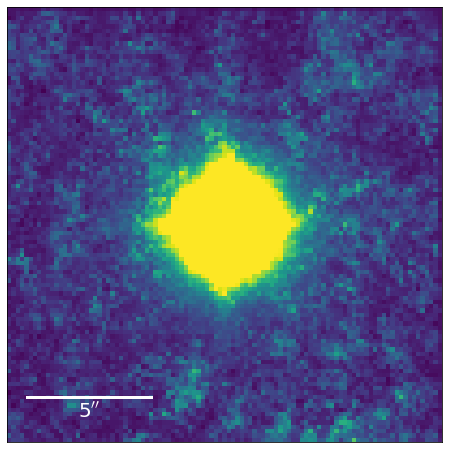

In [39]:
display_single(median_psf);

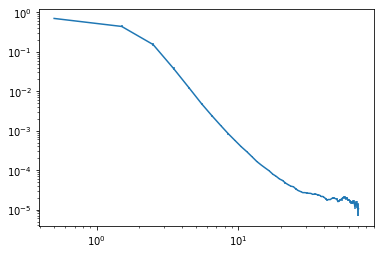

In [40]:
# 1-D PSF
from mrf.utils import azimuthal_average
radius, profile, stdev = azimuthal_average(median_psf, binsize=1)
plt.errorbar(radius, profile, yerr=stdev)
plt.xscale('log')
plt.yscale('log')